# A Model for Rankings

In [1]:
from ranking_system import *
%matplotlib inline

$r_u(t)$ = the ranking of university $u$ at time $t$.

We'll use $t$ to represent time, which will generally think of
as discrete. Thus $r_u(t-1)$ is university $u$'s ranking the year before.

In [2]:
# Time steps
T = 10

# Universities
U = 2

Let $M$ be the number of attributes in the ranking.

In [3]:
# Attributes
M = 2

$y_{i,u}(t)$ = the value of university $u$'s i-th attribute,
where $i$ ranges from 1 to $M$.

$w_i(t)$ is the weightage given to attribute $i$ in the ranking.
This generally does not change frequently.

In [4]:
# Create weightage functions
# Return the weight used for ranking attribute i at time t
# The sum of the M weightage functions at time t must add up to 1

def weightage_research(t):
    """Weight given to research attribute
       Decreases at time t greater than 5"""
    return 0.7 if t < 5 else 0.6

def weightage_average_class_size(t):
    """Weight given to average class size attribute
       Increases at time t greater than 5"""
    return 0.3 if t < 5 else 0.4

The _valuation_ functions $V_i$ need a little explanation.

Think of them as the true valuation of a particular attribute, complete with
lower/upper bounds and potential non-linearities.

For example, consider the attribute "average class size". A ranking could ignore class sizes below 5, and could likewise scale up non-linearly so that a class size of 300 is not much worse than a class size of 200. This means that one could have a step-like $V_i$ function for class sizes to give us the actual value used in the weighted score.

In [ ]:
# Create valuation functions

def valuation_research(value, max_value, steepness):
    """Valuation given to the research attribute
    max_value - The maximum possible input value
    steepness - The steepness factor from 1(low) to 5(high)"""
    # S-shaped curve.
    # Map the value from 0 to max_value to from 0 to steepness factor.
    # The hyperbolic tangent function used as a sigmoid to make S curve.
    # Idea: research spending is intially beneficial but the benefit
    # becomes constrained after a certain spending amount.
    return 100 * np.tanh(np.interp(value, [0, max_value], [0, steepness]))

def valuation_average_class_size(average_class_size):
    """Valuation given to the average class size attribute"""
    # Step like function for average class size
    if average_class_size < 20:
        # Classes with fewer than 20 students receive the most credit
        return 100
    elif 20 <= average_class_size < 30:
        # Classes with 20 to 29 students score second highest
        return 75
    elif 30 <= average_class_size < 40:
        # Classes with 30 to 39 students score third highest
        return 50
    elif 40 <= average_class_size < 50:
        # Classes with 40 to 49 students score fourth highest
        return 25
    else
        # Classes that are 50 or more students receive no credit
        return 0

# Create a list of M attributes 
# Parameters: name, weightage function, valuation function
attributes = [Attribute('Research',
                        weightage_research,
                        valuation_research),
              Attribute('Average Class Size',
                        weightage_average_class_size,
                        valuation_average_class_size)]

We will now define the _score_ of a university as

$$
     \mu_u(t) = \sum_{i} w_i(t) V_i(y_{i,u}(t))
$$

The ranking then, is just an ordering of the universities in epoch
$t$ using their $\mu_u(t)$ values.

,University,Time,Rank,Score,Normalized Score
0,University 1,1,2,71.82,74
1,University 2,1,1,96.58,100
2,University 1,2,2,99.13,98
3,University 2,2,1,100.87,100
...,...,...,...,...,...
16,University 1,9,1,169.76,100
17,University 2,9,2,154.69,91
18,University 1,10,1,174.77,100
19,University 2,10,2,155.79,89


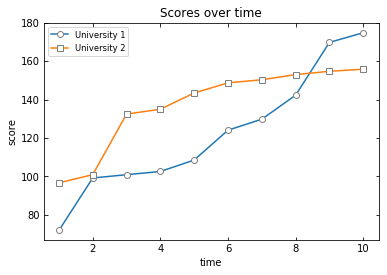

In [5]:
# Create a new model
model = RankingModel(U, attributes, random_seed=13579)

# Run the model
model.run(T)

# Display the scores and ranking
display_ranking(model, all_rows=False)

# Plot the university score over time
line_plot(get_score_by_agent(model), 'time', 'score', 'Scores over time')